# Mock Analysis

This is a mock analysis of the ASUU Strike Project. This is to help us figure out what to do with the data and optimise the process.

### Import packages

In [226]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

### Load data into dataframe

In [167]:
sample_df = pd.read_csv("sample.csv")

sample_df.head()

,Timestamp,Are you a student of UNILAG?,Current level of study \n,How old are you?,What is your gender?,Marital Status,What's your faculty?,What is your department?,How has the just concluded strike affected you ?,Did you acquire any skill relevant to your course of study?,...,How would you rate your preparation for the exams ? [After Strike],How would you rate the quality of your lectures? [Before Strike],How would you rate the quality of your lectures? [After Strike],How confident are you in the significance of your academics [Before Strike],How confident are you in the significance of your academics [After Strike],What was your CGPA before the strike?,What is your current CGPA?\nDon't be shy,Were you employed during the strike?,Did you quit the job when the strike was called-off,"Would you like to be contacted for follow-up questions? If so, kindly drop your email.\nOnly drop your email if you're comfortable doing so!"
0,2/9/2023 10:18:58,Yes,400level,22–24,Female,Single,Management Science,Finance,1. It has increased the amount of years I’m to...,Yes,...,Poor,Neutral,Poor,Good,Neutral,4.30,4.09,Yes,No,NaN
1,2/9/2023 10:39:25,Yes,300level,19–21,Male,Single,Science,Statistics,Positively,Yes,...,Good,Good,Good,Good,Good,4.51,4.51,Yes,No,NaN
2,2/9/2023 10:59:26,Yes,300level,25–27,Male,Single,Science,Botany,It has affected my reading culture and habits,Yes,...,Neutral,Neutral,Poor,Good,Neutral,4.09,4.08,No,No,NaN
3,2/9/2023 23:01:53,Yes,400level,22–24,Male,Single,Science,Geophysics,NIL,No,...,Neutral,Neutral,Poor,Neutral,Poor,3.88,3.56,No,No,NaN
4,2/9/2023 23:03:22,Yes,200level,16–18,Female,Married,Engineering,Civil Engineering,Made me a millionaire,No,...,Neutral,Neutral,Neutral,Neutral,Neutral,2.96,2.02,Yes,No,NaN


In [168]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 22 columns):
 #   Column                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                       --------------  -----  
 0   Timestamp                                                                                                                                    14 non-null     object 
 1   Are you a student of UNILAG?                                                                                                                 14 non-null     object 
 2   Current level of study 
                                                                                                                     14 non-null     object 
 3   How old are you?                          

## Clean data

Drop all non-UNILAG students

In [169]:
sample_df = sample_df[sample_df["Are you a student of UNILAG?"] == "Yes"]

Drop unrequired columns

In [170]:
cols_to_drop = ["Timestamp", 
                "Are you a student of UNILAG?",
                "How has the just concluded strike affected you ?",
                "What challenges did you experience during resumption after the long strike?",
                "Would you like to be contacted for follow-up questions? If so, kindly drop your email.\nOnly drop your email if you're comfortable doing so!",
                ]
sample_df.drop(columns=cols_to_drop, axis=1, inplace=True)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 13
Data columns (total 17 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Current level of study 
                                                     13 non-null     object 
 1   How old are you?                                                             13 non-null     object 
 2   What is your gender?                                                         13 non-null     object 
 3   Marital  Status                                                              13 non-null     object 
 4   What's your faculty?                                                         13 non-null     object 
 5   What is your department?                                                     13 non-null     object 
 6   Did you acquire any skill relevant to your c

Rename columns

In [171]:
new_col_names = [
    "level", "age", "gender", "marital_status", "faculty", "department", "skill", "prep_before", "prep_after", 
    "quality_before", "quality_after", "confidence_before", "confidence_after", 
    "cgpa_before", "cgpa_after", "employment", "quit_job"
]

sample_df.columns = new_col_names

sample_df.head()

,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,cgpa_before,cgpa_after,employment,quit_job
0,400level,22–24,Female,Single,Management Science,Finance,Yes,Neutral,Poor,Neutral,Poor,Good,Neutral,4.30,4.09,Yes,No
1,300level,19–21,Male,Single,Science,Statistics,Yes,Good,Good,Good,Good,Good,Good,4.51,4.51,Yes,No
2,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,4.09,4.08,No,No
3,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,3.88,3.56,No,No
4,200level,16–18,Female,Married,Engineering,Civil Engineering,No,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,2.96,2.02,Yes,No


**Remove Outliers**

Ouliers include all 100 Level students, as they have nothing to compare against. Some students might have entered wrong values for CGPA. Take note of that as well.

In [172]:
# remove 100 level students
sample_df = sample_df[sample_df["level"]!="100level"]

# remove outliers (CGPA = 0)
sample_df = sample_df[
    (sample_df["cgpa_before"]>0) & (sample_df["cgpa_after"]>0)
    ]
sample_df.describe()

,cgpa_before,cgpa_after
count,11.000000,11.000000
mean,3.999091,3.820909
std,0.557018,0.807235
min,2.960000,2.020000
25%,3.640000,3.580000
50%,4.090000,4.080000
75%,4.390000,4.295000
max,4.710000,4.790000


Expand Dataframe to Simulate Target Reach **[Test Only]**

In [173]:
# expand dataframe to simulate 2000 respondents
new_sample = pd.concat([sample_df]*200, ignore_index=True)


# Predict random CGPA values for richer data
# Subtracted 0.5 from std to ensure no values above 5.0 in CGPA

std_before = new_sample.cgpa_before.std() - 0.5 
std_after = new_sample.cgpa_after.std() - 0.5
mean_before = new_sample.cgpa_before.mean()
mean_after = new_sample.cgpa_after.mean()

np.random.seed(21)

new_sample["cgpa_before"] = np.random.normal(mean_before, std_before, size=len(new_sample))
new_sample["cgpa_after"] = np.random.normal(mean_after, std_after, size=len(new_sample))

Compute target variable

In [174]:
new_sample["cgpa_change"] = new_sample["cgpa_after"] - new_sample["cgpa_before"]
new_sample.describe()

,cgpa_before,cgpa_after,cgpa_change
count,2200.000000,2200.000000,2200.000000
mean,3.998783,3.834110,-0.164673
std,0.031280,0.266917,0.267867
min,3.878830,2.824106,-1.204614
25%,3.977428,3.652785,-0.349770
50%,3.998953,3.831117,-0.172139
75%,4.019398,4.007192,0.005840
max,4.120521,4.772331,0.785492


## Exploratory Data Analysis

In [175]:
sns.set_palette("pastel")

How vdjjbjdnjdknkdnkdmdl

In [176]:
new_sample.head()

,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,cgpa_before,cgpa_after,employment,quit_job,cgpa_change
0,400level,22–24,Female,Single,Management Science,Finance,Yes,Neutral,Poor,Neutral,Poor,Good,Neutral,3.997469,3.919087,Yes,No,-0.078382
1,300level,19–21,Male,Single,Science,Statistics,Yes,Good,Good,Good,Good,Good,Good,3.995620,3.968665,Yes,No,-0.026955
2,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,4.031612,3.585951,No,No,-0.445661
3,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,3.959860,4.051120,No,No,0.091260
4,200level,16–18,Female,Married,Engineering,Civil Engineering,No,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,4.022359,3.777755,Yes,No,-0.244605


How did CGPA distribution change before and after the strike?

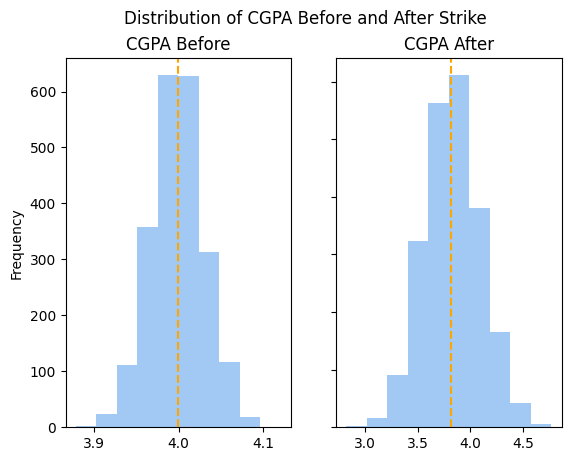

In [177]:
fig, ax = plt.subplots(1, 2)
new_sample.cgpa_before.plot(kind="hist", ax=ax[0], title="CGPA Before")
ax[0].axvline(mean_before, color="orange", linestyle="--")

new_sample.cgpa_after.plot(kind="hist", ax=ax[1], title="CGPA After", sharey=True)
ax[1].axvline(mean_after, color="orange", linestyle="--")

plt.suptitle("Distribution of CGPA Before and After Strike");

How does this change for male and female students?

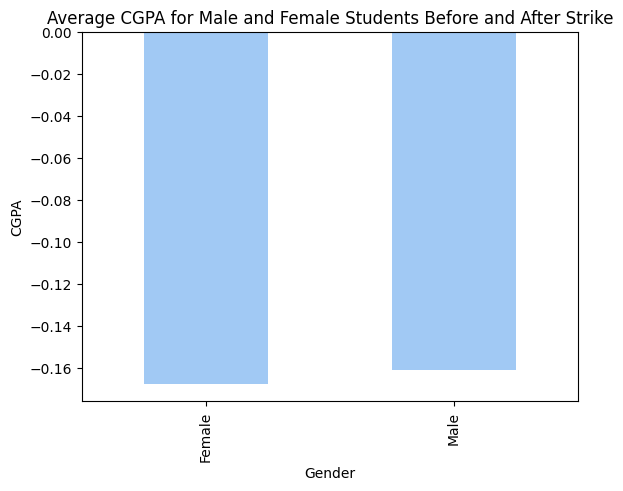

In [178]:
new_sample.groupby("gender").mean().cgpa_change.plot(kind="bar")
plt.title("Average CGPA for Male and Female Students Before and After Strike")
plt.xlabel("Gender")
plt.ylabel("CGPA");

Did employed students struggle more?

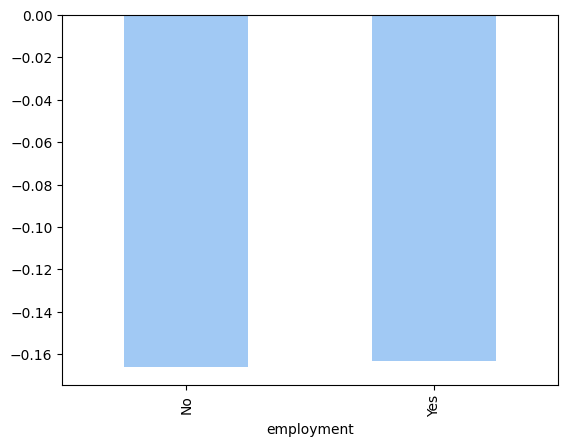

In [179]:
new_sample.groupby("employment").mean().cgpa_change.plot(kind="bar");

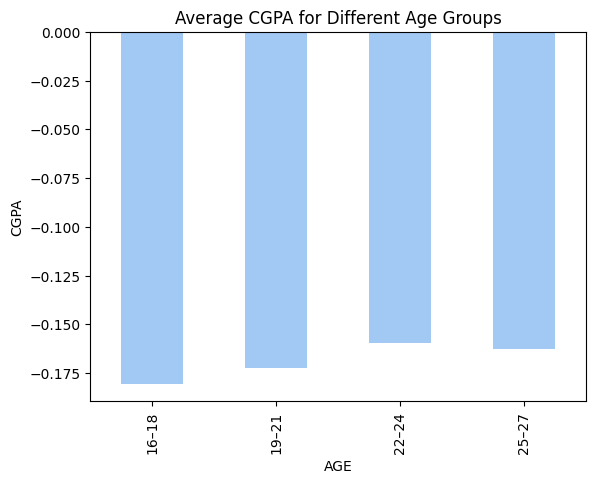

In [180]:
new_sample.groupby("age").mean().cgpa_change.plot(kind="bar")
plt.title("Average CGPA for Different Age Groups")
plt.xlabel("Age")
plt.ylabel("CGPA");

## Build Model

In [196]:
df = new_sample.drop(columns=["cgpa_before", "cgpa_after"])

#### Linear Regression

In [203]:
# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(df.drop(columns="cgpa_change"))
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(df.drop(columns="cgpa_change").columns))
df = pd.concat([df, encoded_df], axis=1)

#### Select features and target

In [209]:
target = "cgpa_change"
X = df.drop(columns=target)
y = df[target]

Split data into test and training sets

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Split training data into training and validation data

In [206]:
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
)

Make pipeline

In [211]:
# create the column transformer to one-hot encode the categorical features
categorical_features = X.columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

In [217]:
# create the linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])


# fit the model to the training data
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['level', 'age', 'gender', 'marital_status', 'faculty', 'department',
       'skill', 'prep_before', 'prep_after', 'quality_before', 'quality_after',
       'confidence_before', 'confidence_after', 'employment', 'quit_job',
       'level_200level', 'level_300level', 'lev...
       'quality_before_Good', 'quality_before_Neutral', 'quality_before_Poor',
       'quality_after_Good', 'quality_after_Neutral', 'quality_after_Poor',
       'confidence_before_Good', 'confidence_before_Neutral',
       'confidence_after_Good', 'confidence_after_Neutral',
       'confidence_after_Poor', 'employment_No', 'employment_Yes',
       'quit_job_No', 'quit_job_Yes'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [231]:
# evaluate the model's performance on the training data
y_train_mean = y_train.mean()
y_train_baseline = [y_train_mean]*len(y_train)
baseline_mse = mean_squared_error(y_train, y_train_baseline)
training_mse = mean_squared_error(y_train, model.predict(X_train))
print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}""")


Baseline MSE: 0.06921 
Training MSE: 0.06954


In [232]:
# predict the target variable for the validation data
y_pred_val = model.predict(X_val)


# evaluate the model's performance on the validation data
y_val_mean = y_val.mean()
y_val_baseline = [y_val_mean]*len(y_val)
val_mse = mean_squared_error(y_val, y_pred_val)

print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}
Validation MSE: {round(val_mse, 5)}""")


Baseline MSE: 0.06921 
Training MSE: 0.06954
Validation MSE: 0.07751


In [234]:
# perform k-fold cross-validation
from sklearn.model_selection import cross_val_score


scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# calculate the mean and standard deviation of the scores
mean_mse = np.mean(-scores)
std_mse = np.std(-scores)

# print the mean and standard deviation of the scores
print(f"Mean MSE: {mean_mse:.5f}")
print(f"Standard deviation of MSE: {std_mse:.5f}")

Mean MSE: 0.07254
Standard deviation of MSE: 0.00519


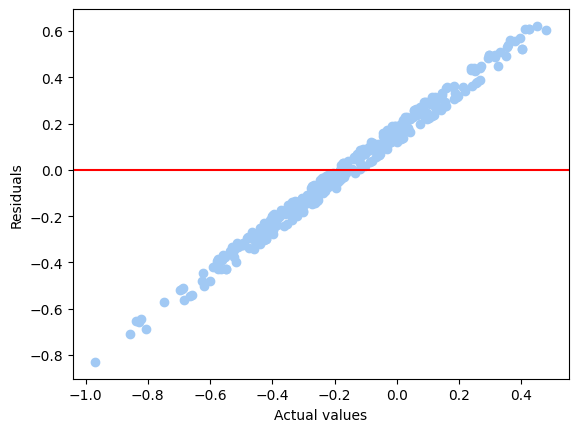

In [237]:
# calculate the residuals
residuals = y_val - y_pred_val

# plot the residuals
plt.scatter(y_val, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.show()

In [225]:
# evaluate the model's performance on the test data
mse = mean_squared_error(y_val, y_pred_val)
mse

0.07751305636762683

In [214]:
# dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)

# make_pipeline(
#     OrdinalEncoder(),
#     DecisionTreeClassifier(max_depth=6, random_state=42)
# )

# Fit model to training data
# dt_model.fit(X_train, y_train)

#### Decision Tree Classifier

In [243]:
def categorize_change(val):
    category = ""

    if abs(val) >= 1:
        category+="EXTREME"
    elif abs(val) >= 0.5:
        category+="VERY HIGH"
    elif abs(val) >= 0.2:
        category+="HIGH"
    elif abs(val) >= 0.1:
        category+="MEDIUM"
    elif abs(val) >= 0.05:
        category+="LOW"
    else:
        category+=" VERY LOW"
        
    if val > 0:
        category+= "-RISE"
    else:
        category+= "-DROP"
    
    return category

In [253]:
df = new_sample.drop(columns=["cgpa_before", "cgpa_after"])

df["cgpa_change"] = df["cgpa_change"].apply(categorize_change)
df.head()

,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,employment,quit_job,cgpa_change
0,400level,22–24,Female,Single,Management Science,Finance,Yes,Neutral,Poor,Neutral,Poor,Good,Neutral,Yes,No,LOW-DROP
1,300level,19–21,Male,Single,Science,Statistics,Yes,Good,Good,Good,Good,Good,Good,Yes,No,VERY LOW-DROP
2,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,No,No,HIGH-DROP
3,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,No,No,LOW-RISE
4,200level,16–18,Female,Married,Engineering,Civil Engineering,No,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Yes,No,HIGH-DROP


<AxesSubplot:>

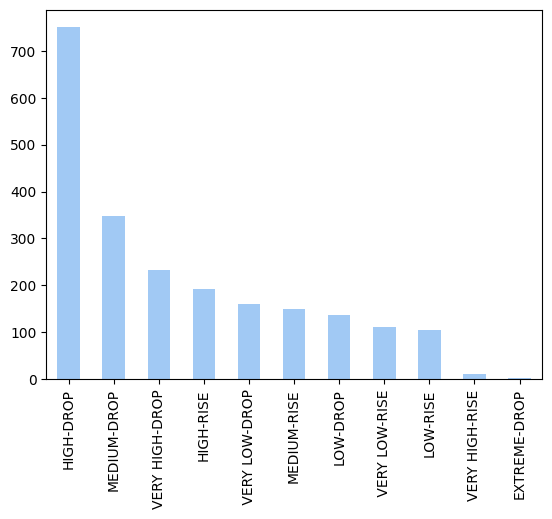

In [265]:
df["cgpa_change"].value_counts().sort_values(ascending=False).plot(kind="bar")

In [254]:
target = "cgpa_change"
X = df.drop(columns=target)
y = df[target]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
)

In [257]:
dt_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=6, random_state=42)
)

dt_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [258]:
from sklearn.metrics import accuracy_score


acc_train = accuracy_score(y_train, dt_model.predict(X_train))
acc_val = dt_model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.35
Validation Accuracy: 0.34


### Baseline

### Iterate

### Evaluate

## Communicate